In [1]:
!pip install cvxopt -q
!pip install optuna -q

In [314]:
import sklearn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score


import os
import optuna
import random
import cvxopt
import cvxopt.solvers
import sklearn

cvxopt.solvers.options['show_progress'] = False

In [168]:
np.random.seed(42)
random.seed(42)

In [212]:
X_test_ = pd.read_csv('data/Xte.csv',sep=',',index_col=0)
X_train_ = pd.read_csv('data/Xtr.csv',sep=',',index_col=0)

X_test_mat100 = pd.read_csv('data/Xte_mat100.csv',sep=' ',header=None).values
X_train_mat100 = pd.read_csv('data/Xtr_mat100.csv',sep=' ',header=None).values



### This Fuction will help us get the label 

- Label will be  0 or 1 if we use type=0
- label will be -1 or 1 if we use type=-1

In [220]:
def get_label(type=0):
    y = pd.read_csv('data/Ytr.csv',sep=',',index_col=0)
    if type == 0:
        y = y.Bound.values
        return y
    else:
        y['Bound'] = y.Bound.apply(lambda x: -1 if x == 0 else 1)
        y = y.Bound.values
        return y
    
get_label(0)

array([1, 0, 1, ..., 1, 1, 1])

### This function will return train-val split data using sklearns built in train_test_split

In [171]:
def get_train_test(X,y,p):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=p, random_state=42)
    print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

### EDA

In [172]:
# THE DATA 

X_train_.head()

,seq
Id,
0,GAGGGGCTGGGGAGGGGGCTGGCCCAGAGGCACCAGACTCTGCAGA...
1,CGGCCTGGGGGCCACATGTGAGTGCTTACCTGTGTGGGGATGAGGG...
2,GACAACGCCGCTGTCAGCCGCCTTCGACTCACCTGGGAGGTGATGA...
3,GCCTCCCTTGGCACCACGGGAGACCAGTTTTGGAGGGGCGGGGCTG...
4,GCACTACTACACCCATTGCTGTAATAGTAAGTGCCGGTGCCTTCAC...


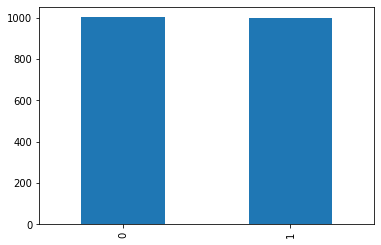

In [173]:
# THE DATA IS PROPORTIONAL DATA 

y['Bound'].value_counts().plot.bar()

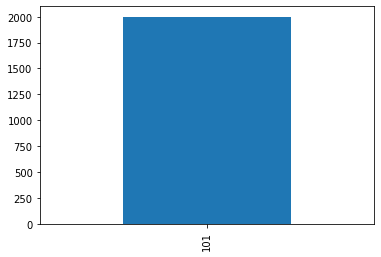

In [174]:
# ADDITIONALLY ALL DATA CONTAINS 101 LENGTH SEQUENCES SO THERE WILL BE NO NEED OF PADDING 

X_train_['Count'] = X_train_.seq.apply(lambda x:len(x))
X_train_['Count'].value_counts().plot.bar()

#  Data Related Experiments

### One Hot Encoding

In [175]:
print('sequence = ', X_train_.seq.values[0])
print('scaled version of One Hot Representation =',X_train_mat100[0])

sequence =  GAGGGGCTGGGGAGGGGGCTGGCCCAGAGGCACCAGACTCTGCAGAACCACCCAGGCATTGTGGGGCTGCCCTGCCACCTGCTGGCCGCTCCTGGTGGCAG
scaled version of One Hot Representation = [0.01086957 0.01086957 0.01086957 0.0326087  0.01086957 0.0326087
 0.01086957 0.         0.         0.01086957 0.0326087  0.
 0.         0.01086957 0.02173913 0.01086957 0.01086957 0.01086957
 0.         0.0326087  0.02173913 0.         0.         0.01086957
 0.01086957 0.01086957 0.         0.02173913 0.         0.01086957
 0.01086957 0.04347826 0.         0.01086957 0.01086957 0.01086957
 0.         0.01086957 0.04347826 0.01086957 0.02173913 0.02173913
 0.         0.         0.01086957 0.02173913 0.02173913 0.
 0.         0.         0.         0.01086957 0.         0.0326087
 0.01086957 0.         0.01086957 0.         0.01086957 0.02173913
 0.         0.01086957 0.01086957 0.02173913 0.01086957 0.
 0.01086957 0.01086957 0.01086957 0.         0.         0.
 0.         0.         0.01086957 0.01086957 0.         0.02173913
 0.010

### Ordinal encoding DNA

In [176]:
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['A','C','G','T']))

def ordinal_encoder(sequence):
    integer_encoded = label_encoder.transform(np.array(list(sequence)))
    float_encoded = integer_encoded.astype(float)
    float_encoded[float_encoded == 0] = 0.25
    float_encoded[float_encoded == 1] = 0.50
    float_encoded[float_encoded == 2] = 0.75
    float_encoded[float_encoded == 3] = 1.00 
    return float_encoded

def get_ordinal_data(x_train):
    X_list = []
    for i in x_train:
        X_list.append(ordinal_encoder(i))
    return np.array(X_list)


In [177]:
print('sequence = ', X_train_.seq.values[0])
print('scaled version of One Hot Representation =',get_ordinal_data(X_train_.seq.values)[0])

sequence =  GAGGGGCTGGGGAGGGGGCTGGCCCAGAGGCACCAGACTCTGCAGAACCACCCAGGCATTGTGGGGCTGCCCTGCCACCTGCTGGCCGCTCCTGGTGGCAG
scaled version of One Hot Representation = [0.75 0.25 0.75 0.75 0.75 0.75 0.5  1.   0.75 0.75 0.75 0.75 0.25 0.75
 0.75 0.75 0.75 0.75 0.5  1.   0.75 0.75 0.5  0.5  0.5  0.25 0.75 0.25
 0.75 0.75 0.5  0.25 0.5  0.5  0.25 0.75 0.25 0.5  1.   0.5  1.   0.75
 0.5  0.25 0.75 0.25 0.25 0.5  0.5  0.25 0.5  0.5  0.5  0.25 0.75 0.75
 0.5  0.25 1.   1.   0.75 1.   0.75 0.75 0.75 0.75 0.5  1.   0.75 0.5
 0.5  0.5  1.   0.75 0.5  0.5  0.25 0.5  0.5  1.   0.75 0.5  1.   0.75
 0.75 0.5  0.5  0.75 0.5  1.   0.5  0.5  1.   0.75 0.75 1.   0.75 0.75
 0.5  0.25 0.75]


## K-mer counting/Spectral Embedding

In [275]:
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [276]:
def base2int(c):
    return {'a':0,'c':1,'g':2,'t':3}.get(c,0)

def index(kmer):
    base_idx = np.array([base2int(base) for base in kmer])
    multiplier = 4** np.arange(len(kmer))
    kmer_idx = multiplier.dot(base_idx)
    return kmer_idx
    
    
def spectral_embedding(sequence,kmer_size=3):
    kmers = getKmers(sequence,kmer_size)
    kmer_idxs = [index(kmer) for kmer in kmers]
    one_hot_vector = np.zeros(4**kmer_size)
    
    for kmer_idx in kmer_idxs:
        one_hot_vector[kmer_idx] += 1
    return one_hot_vector


def get_data(kmer_size):
    data = pd.DataFrame(pd.concat([X_train_.seq,X_test_.seq],axis=0))
    train_text = data.seq.values
    # X_train_['kmers'] = X_train_.seq.apply(lambda x:list(spectral_embedding(x,kmer_size=3)))
    kmer_data = []
    for i in train_text:
        kmer_data.append(spectral_embedding(i,kmer_size=kmer_size))

    return np.array(kmer_data)

## Count Vectorizer / TfidfTransformer

In [279]:
def get_count_grams(data,n=6):
    cv = CountVectorizer(analyzer='char',ngram_range=(n,n))
    X = cv.fit_transform(data).toarray()
    return X

def get_tf_idf_grams(data,n=6):
    cv = TfidfVectorizer(analyzer='char',ngram_range=(n,n))
    X = cv.fit_transform(data).toarray()
    return X

In [280]:
# get_count_grams(X_train_.seq.values).shape
# get_tf_idf_grams(X_train_.seq.values).shape

# Algorithm Related Experiments

## 1. Logistic Regression 

In [281]:
class logisticregression():
    def __init__(self,train_data,train_labels,lamda=0.2,lr=0.01,decay=10,batch_size=64,epoch=10,print_every = 10):
        dummy_once = np.ones((len(train_data),1))
        self.train_data = np.hstack((dummy_once,train_data))
        self.train_labels = train_labels
        
        self.params = np.zeros((len(self.train_data[0]),1))
        
        self.lr = lr
        self.epoch = epoch
        self.batch_size = batch_size
        self.print_every = print_every
        self._lambda = lamda
        self.decay = decay
        
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def cost(self,y,y_pred):
        return -np.mean(y*np.log(y_pred)+(1-y)*np.log(1-y_pred))
    
    def gradient(self,y,y_pred,x):
        return np.dot(x.T,(y_pred-y))+(2*(self._lambda/len(self.train_labels ))*self.params)
    
    def train(self):
        for i in range(self.epoch):
            for j in range(len(self.train_labels)//self.batch_size):
                idx = list(np.random.choice(np.arange(len(self.train_labels)),self.batch_size,replace=False))
                data = self.train_data[idx]
                label = self.train_labels[idx]

                y_pred = self.sigmoid(np.dot(data,self.params))
                loss = self.cost(label,y_pred)

                gra = self.gradient(label,y_pred,data)
                self.params -= self.lr*gra

                self.lr *= (1. / (1. + self.decay * i))
            
            if self.print_every:
                if i%self.print_every == 0 or i == self.epoch-1:
                    print('Epoch : {}  Loss: {}'.format(i,loss))
    def predict(self,test_data):
        result = self.sigmoid(np.dot(test_data,self.params[1:])+self.params[0])
        result[result > 0.5 ] = 1
        result[result <= 0.5 ] = 0
        return result
    
    def evaluate(self,test_data,labels):
        accuracy = accuracy_score(self.predict(test_data),labels)
        return accuracy

In [282]:
def cross_validate(x_data,y_data,lr,lamda=0.2,epoch=10,k=4,batch_size=64,decay=10):
    if len(x_data)%k != 0:
        print('cant vsplit',len(x_data),' by ',k)
        return
    
    x_data_splitted = np.vsplit(x_data,k)
    y_data_splitted = np.vsplit(y_data,k)
    
    aggrigate_result = []
    for i in range(len(x_data_splitted)):
        train = []
        test = []
        items = [j for j in range(len(x_data_splitted)) if j !=i ]
        x_test = x_data_splitted[i]
        y_test = y_data_splitted[i]
        for item in items:
            if len(train) == 0:
                x_train = x_data_splitted[item]
                y_train = y_data_splitted[item]
            else:
                x_train = np.concatenate((x_train,x_data_splitted[item]), axis=0)
                y_train = np.concatenate((y_train,y_data_splitted[item]), axis=0)
        
        logistic = logisticregression(x_train,y_train,batch_size=batch_size,lamda=lamda,lr=lr,decay=decay,epoch=epoch,print_every=None)
        logistic.train()
        
        result = logistic.evaluate(x_test,y_test)
        aggrigate_result.append(result)
        
        value = sum(aggrigate_result)/len(aggrigate_result)
    return value

In [286]:
one_hot_result = cross_validate(X_train_mat100,get_label(type=0).reshape(-1,1),k=5,lr=0.01,batch_size=32,lamda=5,epoch=100)
ordinal_result = cross_validate(get_ordinal_data(X_train_.seq.values),get_label(type=0).reshape(-1,1),k=5,lr=0.01,batch_size=32,lamda=5,epoch=100)
kmer_result = cross_validate(get_data(6)[:2000,:],get_label(type=0).reshape(-1,1),k=5,lr=0.01,batch_size=32,lamda=5,epoch=100)
count_result = cross_validate(get_count_grams(X_train_.seq.values,6),get_label(type=0).reshape(-1,1),k=5,lr=0.01,batch_size=32,lamda=5,epoch=100)
tfidf_result = cross_validate(get_tf_idf_grams(X_train_.seq.values,6),get_label(type=0).reshape(-1,1),k=5,lr=0.01,batch_size=32,lamda=5,epoch=100)

In [287]:
final_value = {'One Hot':one_hot_result,'Ordinal':ordinal_result,'K-mer':kmer_result,'Count-Vectorizer':count_result,'Tf-idf':tfidf_result}
final_value

{'Count-Vectorizer': 0.6005,
 'K-mer': 0.6159999999999999,
 'One Hot': 0.49499999999999994,
 'Ordinal': 0.5135,
 'Tf-idf': 0.511}

 ### The First Result Shows The Qualty of the data on non optimized logistic regression model this is not the best value this method can achive but it can show us the quality of the data preprocessing

In [288]:
for k,v in final_value.items():
    print('{} === {}'.format(k,v))

One Hot === 0.49499999999999994
Ordinal === 0.5135
K-mer === 0.6159999999999999
Count-Vectorizer === 0.6005
Tf-idf === 0.511


## Algorithm Related Experiments +  Kernel Related Experiments

We alady implemennted Logistic regression now we will add 

- Ridge Regression
- SVM

In [289]:
def sigma_from_median(X):
    pairwise_diff = X[:, :, None] - X[:, :, None].T
    pairwise_diff *= pairwise_diff
    euclidean_dist = np.sqrt(pairwise_diff.sum(axis=1))
    return np.median(euclidean_dist)

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

def linear_kernel(x1, x2):
    return np.dot(x1, x2.T)

def polynomial_kernel(X1, X2, power=2):
    return np.power((1 + linear_kernel(X1, X2)),power)


def rbf_kernel(X1, X2, sigma=10):
    X2_norm = np.sum(X2 ** 2, axis = -1)
    X1_norm = np.sum(X1 ** 2, axis = -1)
    gamma = 1 / (2 * sigma ** 2)
    K = np.exp(- gamma * (X1_norm[:, None] + X2_norm[None, :] - 2 * np.dot(X1, X2.T)))
    return K


In [290]:
class KernelMethodBase(object):
    '''
    Base class for kernel methods models
    
    Methods
    ----
    fit
    predict
    '''
    kernels_ = {
        'linear': linear_kernel,
        'polynomial': polynomial_kernel,
        'rbf': rbf_kernel,
        'gaussian':gaussian_kernel
    }
    def __init__(self, kernel='linear', **kwargs):
        self.kernel_name = kernel
        self.kernel_function_ = self.kernels_[kernel]
        self.kernel_parameters = self.get_kernel_parameters(**kwargs)
        
    def get_kernel_parameters(self, **kwargs):
        params = {}
        if self.kernel_name == 'rbf' or self.kernel_name == 'gaussian':
            params['sigma'] = kwargs.get('sigma', None)
        if self.kernel_name == 'polynomial':
            params['power'] = kwargs.get('power', None)
            
        
        return params

    def fit(self, X, y, **kwargs):
        return self
        
    def decision_function(self, X):
        pass

    def predict(self, X):
        pass

### Kernel Ridge Regression

In [291]:
class KernelRidgeRegression(KernelMethodBase):
    '''
    Kernel Ridge Regression
    '''
    def __init__(self, lambd=0.1, **kwargs):
        self.lambd = lambd
        # Python 3: replace the following line by
        # super().__init__(**kwargs)
        super(KernelRidgeRegression, self).__init__(**kwargs)

    def fit(self, X, y, sample_weights=None):
        n, p = X.shape
        assert (n == len(y))
    
        self.X_train = X
        self.y_train = y
        
        if sample_weights is not None:
            w_sqrt = np.sqrt(sample_weights)
            self.X_train = self.X_train * w_sqrt[:, None]
            self.y_train = self.y_train * w_sqrt
        
        A = self.kernel_function_(X,X,**self.kernel_parameters)
        A[np.diag_indices_from(A)] = np.add(A[np.diag_indices_from(A)],n*self.lambd)
        # self.alpha = (K + n lambda I)^-1 y
        self.alpha = np.linalg.solve(A , self.y_train)

        return self
    
    def decision_function(self, X):
        K_x = self.kernel_function_(X,self.X_train, **self.kernel_parameters)
        return K_x.dot(self.alpha)
    
    def predict(self, X):
        return self.decision_function(X)

In [324]:
def cross_validate(x_data,y_data,model,kernel=None,lambd=0.2,sigma=0.5,k=5,power=2):
    if len(x_data)%k != 0:
        print('cant vsplit',len(x_data),' by ',k)
        return
    
    x_data_splitted = np.vsplit(x_data,k)
    y_data_splitted = np.vsplit(y_data.reshape(-1,1),k)
    
    aggrigate_result = []
    for i in range(len(x_data_splitted)):
        train = []
        test = []
        items = [j for j in range(len(x_data_splitted)) if j !=i ]
        x_test = x_data_splitted[i]
        y_test = y_data_splitted[i]
        for item in items:
            if len(train) == 0:
                x_train = x_data_splitted[item]
                y_train = y_data_splitted[item]
            else:
                x_train = np.concatenate((x_train,x_data_splitted[item]), axis=0)
                y_train = np.concatenate((y_train,y_data_splitted[item]), axis=0)
        
        if model == 'KernelRidgeRegression':
            model = KernelRidgeRegression(
                    kernel=kernel,
                    lambd=lambd,
                    sigma=sigma,
                    power=power
                ).fit(x_train, y_train)
            result =sum(np.sign(model.predict(x_test))==y_test)/len(y_test)#roc_auc_score(np.sign(model.predict(x_test)),y_test) #
        elif model == 'logistic':
            logistic = logisticregression(x_train,y_train,batch_size=batch_size,lamda=lamda,lr=lr,decay=decay,epoch=epoch,print_every=None)
            logistic.train()

            result = logistic.evaluate(x_test,y_test)
            
        aggrigate_result.append(result)
        
        value = sum(aggrigate_result)/len(aggrigate_result)
    return value

In [325]:
get_data(6)[0,:]

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
def objective(trial):
    lambd = trial.suggest_float('lambd', 1e-5, 100.0)
    sigma = trial.suggest_loguniform('sigma', 10, 150)
    k =  trial.suggest_categorical('k', [4,5,8])
    power =  trial.suggest_int('power', 2,5)
    kmer_size =  trial.suggest_int('kmer_size', 1,8)
    kernel =  trial.suggest_categorical('kernel', ['linear','polynomial'])
    
    return cross_validate(get_data(kmer_size)[:2000,:],get_label(type=-1),model='KernelRidgeRegression',kernel=kernel,lambd=lambd,k=k,sigma=sigma,power=power)


# cross_validate(X_train_mat100, y,lamda=0.01,k=4)
import optuna

sampler = optuna.samplers.TPESampler()
study = optuna.create_study(sampler=sampler, direction='maximize')
df = study.optimize(func=objective, n_trials=500,show_progress_bar=True)

/usr/local/lib/python3.6/dist-packages/optuna/_experimental.py:90: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



[I 2020-05-30 17:51:51,923] Finished trial#0 with value: 0.504 with parameters: {'lambd': 35.9121779670735, 'sigma': 37.41698023557889, 'k': 8, 'power': 4, 'kmer_size': 6, 'kernel': 'linear'}. Best is trial#0 with value: 0.504.
[I 2020-05-30 17:51:54,252] Finished trial#1 with value: 0.538 with parameters: {'lambd': 80.38628265833871, 'sigma': 13.323453813820363, 'k': 4, 'power': 3, 'kmer_size': 2, 'kernel': 'polynomial'}. Best is trial#1 with value: 0.538.
[I 2020-05-30 17:51:56,969] Finished trial#2 with value: 0.518 with parameters: {'lambd': 57.175019790205404, 'sigma': 130.73687891683582, 'k': 4, 'power': 4, 'kmer_size': 5, 'kernel': 'linear'}. Best is trial#1 with value: 0.538.
[I 2020-05-30 17:51:59,848] Finished trial#3 with value: 0.508 with parameters: {'lambd': 40.555530964629405, 'sigma': 10.186641703771878, 'k': 8, 'power': 4, 'kmer_size': 6, 'kernel': 'linear'}. Best is trial#1 with value: 0.538.
[I 2020-05-30 17:52:04,213] Finished trial#4 with value: 0.644 with paramete

0.5

In [ ]:
X_test_final = get_data(7)[2000:,:]


sumbission = []
for i in range(len(X_test_final)):
    r1 = np.sign(model.predict(X_test_final[i]))
    
    if r1 == 1:
        sumbission.append([i,int(r1)])
    elif r1 == -1:
        sumbission.append([i,0])
    else:
        print('problem')
        
    
# sumbission
df = pd.DataFrame(sumbission)
df.columns = ['Id','Bound']
df.to_csv('cv_65.75_linear_overfitted.csv',index=False)

df.head(15)